In [9]:
import pandas as pd
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv")

In [10]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [11]:
# Prepare data
node_ids = features_df.iloc[:, 0].values
time_steps = features_df.iloc[:, 1].values
X = features_df.iloc[:, 2:].values

# Merge with labels (1=illicit, 2=licit, unknown=unlabeled)
label_map = dict(zip(classes_df['txId'], classes_df['class']))
labels = np.array([label_map.get(nid, 'unknown') for nid in node_ids])

# Filter to labeled data only
labeled_mask = (labels == '1') | (labels == '2')
X_labeled = X[labeled_mask]
y_labeled = (labels[labeled_mask] == '1').astype(int)  # 1=illicit, 0=licit
time_labeled = time_steps[labeled_mask]

print(f"Total samples: {len(X)}")
print(f"Labeled samples: {len(X_labeled)}")
print(f"Illicit: {y_labeled.sum()}, Licit: {(1-y_labeled).sum()}")

Total samples: 203768
Labeled samples: 46564
Illicit: 4545, Licit: 42019


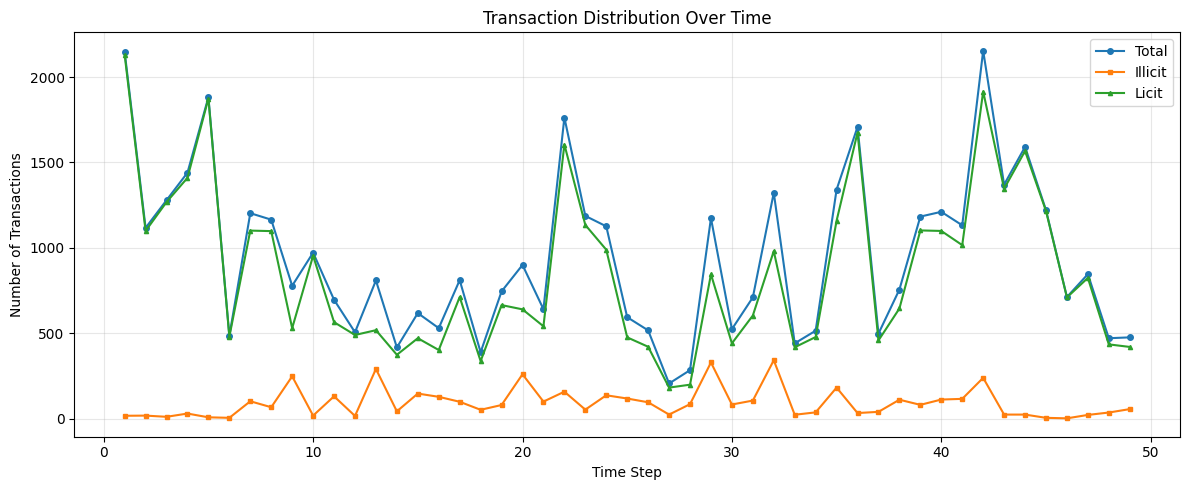

In [12]:
# Plot time step distribution
import matplotlib.pyplot as plt

time_counts = pd.DataFrame({
    'time_step': time_labeled,
    'is_illicit': y_labeled
}).groupby('time_step').agg(
    total=('is_illicit', 'count'),
    illicit=('is_illicit', 'sum')
).reset_index()

time_counts['licit'] = time_counts['total'] - time_counts['illicit']

plt.figure(figsize=(12, 5))
plt.plot(time_counts['time_step'], time_counts['total'], label='Total', marker='o', markersize=4)
plt.plot(time_counts['time_step'], time_counts['illicit'], label='Illicit', marker='s', markersize=3)
plt.plot(time_counts['time_step'], time_counts['licit'], label='Licit', marker='^', markersize=3)
plt.xlabel('Time Step')
plt.ylabel('Number of Transactions')
plt.title('Transaction Distribution Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# Temporal split: train on earlier time steps, test on later ones
split_time = 43  # Use first 43 time steps for train, rest for test

train_mask = time_labeled <= split_time
test_mask = time_labeled > split_time

X_train, y_train = X_labeled[train_mask], y_labeled[train_mask]
X_test, y_test = X_labeled[test_mask], y_labeled[test_mask]

print(f"Train set: {len(X_train)} samples (time steps 1-{split_time})")
print(f"  Illicit: {y_train.sum()}, Licit: {(1-y_train).sum()}")
print(f"Test set: {len(X_test)} samples (time steps {split_time+1}-49)")
print(f"  Illicit: {y_test.sum()}, Licit: {(1-y_test).sum()}")

Train set: 41247 samples (time steps 1-43)
  Illicit: 4400, Licit: 36847
Test set: 5317 samples (time steps 44-49)
  Illicit: 145, Licit: 5172


In [14]:
# Parameter grid with cardinality 3
param_grid = {
    'reg_alpha': [0.1, 1.0, 10.0],      # L1 regularization
    'reg_lambda': [0.1, 1.0, 10.0],     # L2 regularization
    'max_depth': [4, 6, 8],             # Tree depth
    'learning_rate': [0.01, 0.1, 0.3],  # Step size shrinkage
    'subsample': [0.7, 0.8, 1.0],       # Row sampling ratio
}

base_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=100
)

grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=3,
    scoring='roc_auc',  
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

model = grid_search.best_estimator_

Starting GridSearchCV...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.7}
Best CV ROC-AUC: 0.9852


In [16]:
# Evaluate model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("Model Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print(f"  PR-AUC:    {pr_auc:.4f}")

Model Performance:
  Accuracy:  0.9520
  Precision: 0.1944
  Recall:    0.2414
  F1 Score:  0.2154
  ROC-AUC:   0.9193
  PR-AUC:    0.1784
